Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

## Instructions
0. If you haven't already, follow [the setup instructions here](https://jennselby.github.io/MachineLearningCourseNotes/#setting-up-python3) to get all necessary software installed.
0. To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`
0. Read through the code in the following sections:
    * [Define game environment and replay classes](#Define-game-environment-and-replay-classes)
    * [Define functions to create model, train, and visualize](#Define-functions-to-create-model,-train,-and-visualize)
    * [Try untrained model](#Try-untrained-model)
    * [Train and assess model](#Train-and-assess-model)
0. Complete some of the [Possible Exercises](#Possible-Exercises)

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define game environment and replay classes
The idea in this FallingFruit game is that the user has to move to try to dodge the fruit. If they dodge it, they win and the game is over. If they get hit by it, they lose and the game is over. We are trying to teach the computer to play this game.

In [2]:
class FallingFruit(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit by fruit
            else:
                return 1 # it dodged the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

##  Define functions to create model, train, and visualize

In [114]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10

def build_model(game=FallingFruit):
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = game(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, env, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)
    
    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=10):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, env, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()
        
        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, env, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Try untrained model

In [4]:
model, env, exp_replay = build_model()

Rewards in Animation: [1]


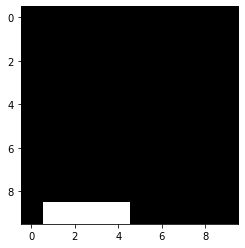

In [106]:
animation = create_animation(model, env, num_episodes=1)
IPython.display.HTML(animation.to_jshtml())

## Train and assess model

See how much better it is at dodging the fruit

Episodes 0001-0010/0100 | Loss 0.0420 | Rewards [-1, 1, -1, -1, 1, -1, 1, 1, 1, 1]
Episodes 0011-0020/0100 | Loss 0.0232 | Rewards [1, -1, -1, 1, 1, 1, -1, -1, 1, 1]
Episodes 0021-0030/0100 | Loss 0.0315 | Rewards [1, -1, 1, -1, -1, 1, 1, 1, -1, 1]
Episodes 0031-0040/0100 | Loss 0.0448 | Rewards [1, 1, -1, -1, -1, 1, -1, 1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0196 | Rewards [-1, -1, -1, 1, 1, -1, -1, -1, 1, 1]
Episodes 0051-0060/0100 | Loss 0.0246 | Rewards [1, 1, 1, -1, 1, 1, -1, -1, -1, 1]
Episodes 0061-0070/0100 | Loss 0.0300 | Rewards [1, 1, 1, -1, 1, 1, -1, 1, 1, 1]
Episodes 0071-0080/0100 | Loss 0.0145 | Rewards [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]
Episodes 0081-0090/0100 | Loss 0.0164 | Rewards [1, -1, 1, 1, 1, -1, 1, -1, 1, 1]
Episodes 0091-0100/0100 | Loss 0.0203 | Rewards [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]
Rewards in Animation: [-1, 1, 1, 1, 1, 1, -1, 1, 1, 1]


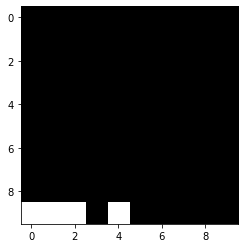

In [6]:
train_model(model, env, exp_replay, num_episodes=100)
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises
1. Standard Difficulty: Add a validation function, to make it easier to assess models.
1. Advanced Difficulty: We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Standard Difficulty: Change the code so that the player is trying to catch the fruit instead of dodging it.
1. Advanced Difficulty: Change the code so the episode keeps going until the player is hit by the fruit. (To test that this is working, you may want to change the number of episodes in the animation to 1.) How should this change the rewards that the model gets?
1. Advanced Difficulty: Change the game to something entirely different.
1. Standard Difficulty: Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.

#### 1

In [7]:
def model_score(model, env, num_episodes, disp_results=False):
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            episode_reward += reward
        rewards.append(episode_reward)
        score=sum(rewards)/num_episodes
    
    if disp_results:
        print(f'Rewards: {rewards}')
    print(f'Score: {score}')
    
    return(score)

In [20]:
model_score(model, env, 100)

Score: 0.7


0.7

#### 2

In [9]:
kernel_size=3

def build_model_conv():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Reshape((grid_size, grid_size, 1), input_shape=(grid_size**2, 1)))
    model.add(Conv2D(filters=1, kernel_size=kernel_size))
    model.add(Reshape((1,(grid_size-kernel_size+1)**2)))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = FallingFruit(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

In [10]:
conv_model, env, exp_replay = build_model_conv()

In [12]:
train_model(conv_model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.0232 | Rewards [1, 1, 1, -1, -1, 1, 1, 1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0441 | Rewards [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]
Episodes 0021-0030/0100 | Loss 0.0413 | Rewards [-1, 1, -1, 1, 1, -1, 1, 1, -1, 1]
Episodes 0031-0040/0100 | Loss 0.0439 | Rewards [1, 1, -1, 1, 1, -1, -1, 1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0542 | Rewards [1, 1, 1, 1, -1, 1, -1, 1, 1, -1]
Episodes 0051-0060/0100 | Loss 0.0210 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, -1]
Episodes 0061-0070/0100 | Loss 0.0329 | Rewards [1, 1, -1, 1, -1, -1, 1, 1, -1, -1]
Episodes 0071-0080/0100 | Loss 0.0139 | Rewards [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0081-0090/0100 | Loss 0.0321 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0440 | Rewards [1, -1, 1, 1, 1, 1, 1, 1, 1, -1]
Score: 0.8


0.8

In [19]:
model_score(conv_model, env, 100)

Score: 0.46


0.46

The convolutional model, at least in this case, performed quite a bit worse than the non-convolutional model, with a much lower final score.

#### 3

In [13]:
class CatchingFruit(FallingFruit):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        super().__init__(grid_size=grid_size)

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it fell, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return 1 # it catched a fruit
            else:
                return -1 # it missed the fruit
        else:
            return 0 # the fruit is still in the air

In [14]:
catch_model, catch_env, exp_replay = build_model(game=CatchingFruit)

In [15]:
train_model(catch_model, catch_env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.0226 | Rewards [-1, -1, 1, -1, -1, 1, -1, -1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0328 | Rewards [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
Episodes 0021-0030/0100 | Loss 0.0334 | Rewards [1, -1, 1, -1, 1, 1, -1, 1, 1, -1]
Episodes 0031-0040/0100 | Loss 0.0259 | Rewards [-1, 1, -1, 1, -1, -1, 1, 1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0567 | Rewards [-1, -1, -1, 1, -1, -1, 1, -1, -1, -1]
Episodes 0051-0060/0100 | Loss 0.0220 | Rewards [1, 1, -1, 1, -1, 1, 1, -1, -1, 1]
Episodes 0061-0070/0100 | Loss 0.0347 | Rewards [1, 1, 1, -1, 1, 1, -1, -1, -1, -1]
Episodes 0071-0080/0100 | Loss 0.0204 | Rewards [-1, 1, 1, 1, 1, -1, 1, -1, 1, 1]
Episodes 0081-0090/0100 | Loss 0.0325 | Rewards [1, -1, 1, -1, -1, -1, 1, -1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0161 | Rewards [1, 1, -1, -1, 1, -1, -1, -1, 1, 1]
Score: -0.2


-0.2

In [24]:
model_score(catch_model, catch_env, 100)

Score: 0.0


0.0

Rewards in Animation: [1, -1, -1, 1, -1, 1, 1, -1, 1, 1]


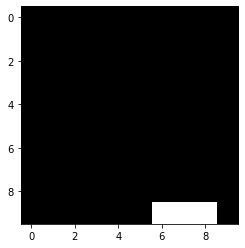

In [99]:
animation = create_animation(catch_model, catch_env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

Unsurprisingly, the model performs quite a bit worse when trying to catch the fruit, as catching the fruit requires the player to actually line up with the fruit, with only a 3-pixel window, while avoiding the fruit is (in effect) a 7-pixel window.

#### 4

In [220]:
class ContinualFallingFruit(FallingFruit):
    def __init__(self, grid_size=10, game_cap=100):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        super().__init__(grid_size=grid_size)
        self.game_cap = game_cap
        self.turns=0

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        self.fruit_reset()
        
        self.turns+=1
        episode_over = (reward == -1) or (self.turns==self.game_cap) 
        # if the reward is zero, the fruit is still in the air
        # also, the game length is limited to 100 turns
        
        # in this version of the game, we don't actually need to have a penalty for hitting the fruit
        if reward == -1:
            reward = 0
            
            
        return observation, reward, episode_over
        
    def fruit_reset(self):
        _, fruit_y, player_center = self.state
        
        if fruit_y == self.grid_size-1:
            fruit_x = random.randint(0, self.grid_size-1)
            fruit_y = 0
            self.state = np.asarray([fruit_x, fruit_y, player_center])
            
    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.turns = 0
        self.state = np.asarray([fruit_x, fruit_y, player_center])

In [30]:
contin_model, contin_env, exp_replay = build_model(game=ContinualFallingFruit)

Rewards in Animation: [3]


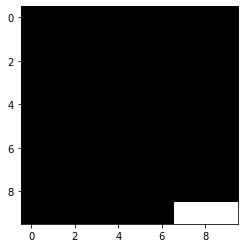

In [26]:
animation = create_animation(contin_model, contin_env, num_episodes=1)
IPython.display.HTML(animation.to_jshtml())

Changing the model like this has now made it so that the reward can be any non-negative integer (capped at 100 by default, but that could be changed).

#### 5

In [221]:
class FindFruit():
    def __init__(self, grid_size=10, game_cap=20):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.game_cap = game_cap
        self.min_player_center=1
        self.max_player_center=grid_size-1
        self.turns = 0
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right, 3 for down, 4 for up)
        
        y-coordinates are inverted, so signs are correct
        
        Moves player according to action. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = [-1, 0]
        elif action == 1:  # stay
            movement = [0, 0]
        elif action == 2: # right
            movement = [1, 0]
        elif action == 3: # down
            movement = [0, 1] 
        elif action == 4: # up
            movement = [0, -1] 
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center_x, player_center_y = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center_x = min(max(self.min_player_center, player_center_x + movement[0]), self.max_player_center)
        new_player_center_y = min(max(self.min_player_center, player_center_y + movement[1]), self.max_player_center)
        
        out = np.asarray([fruit_x, fruit_y, new_player_center_x, new_player_center_y])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center_x, player_center_y = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[player_center_y, player_center_x] = 1  # draw 1-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 20-self.turns if the fruit was found and 0 if it is still in the field.
        '''
        fruit_x, fruit_y, player_center_x, player_center_y = self.state
        if abs(fruit_x - player_center_x)+abs(fruit_y-player_center_y) == 0:
            return 20-self.turns # it found the fruit
        else:
            return 0 # the fruit is still in the field

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        self.turns+=1
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) or (self.turns == self.game_cap) 
        # if the reward is zero, the fruit is still in the field
        # ends game after game_cap turns
        return observation, reward, episode_over

    def reset(self):
        '''
        Resets internal state
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = random.randint(0, self.grid_size-1)
        player_center_x = random.randint(self.min_player_center, self.max_player_center)
        player_center_y = random.randint(self.min_player_center, self.max_player_center)
        self.turns=0
        self.state = np.asarray([fruit_x, fruit_y, player_center_x, player_center_y])

In [84]:
num_actions = 5
find_model, find_env, exp_replay = build_model(game=FindFruit)

Rewards in Animation: [0]


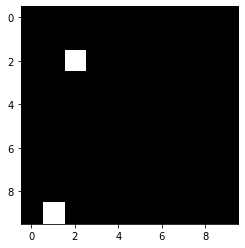

In [85]:
animation = create_animation(find_model, find_env, num_episodes=1)
IPython.display.HTML(animation.to_jshtml())

Unfortunately, training this just was impossibly slow.

#### 6

In [108]:
def move_take_step(exp_replay, model, env, starting_observation):
    """
        This version of take_step will encourage the model to move by introducing random actions when 
        the model outputs a stationary movement
    """
    # get next action
    
    q = model.predict([starting_observation])
    action = np.argmax(q[0])
        
    while action==1:
        action = np.random.randint(0, num_actions, size=1)
  

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over

def move_train_model(model, env, exp_replay, num_episodes, pretrain_episodes=10):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, env, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()
        
        while not episode_over:
            starting_observation, reward, episode_over = \
                move_take_step(exp_replay, model, env, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []

In [121]:
move_model, move_env, exp_replay = build_model()
num_actions = 3

Episodes 0001-0010/0100 | Loss 0.0157 | Rewards [1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
Episodes 0011-0020/0100 | Loss 0.0168 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Episodes 0021-0030/0100 | Loss 0.0265 | Rewards [-1, 1, -1, 1, 1, 1, 1, -1, -1, 1]
Episodes 0031-0040/0100 | Loss 0.0075 | Rewards [-1, 1, 1, -1, 1, 1, -1, -1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0442 | Rewards [1, 1, 1, 1, -1, 1, 1, 1, -1, 1]
Episodes 0051-0060/0100 | Loss 0.0274 | Rewards [-1, 1, 1, -1, 1, -1, -1, 1, -1, 1]
Episodes 0061-0070/0100 | Loss 0.0791 | Rewards [1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
Episodes 0071-0080/0100 | Loss 0.0110 | Rewards [1, 1, -1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0081-0090/0100 | Loss 0.0354 | Rewards [1, 1, 1, -1, 1, -1, 1, -1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0202 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, -1]
Rewards in Animation: [1, -1, -1, -1, 1, 1, 1, 1, 1, -1]


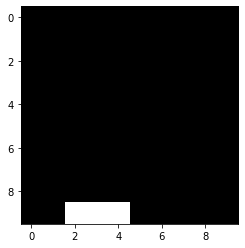

In [119]:
move_train_model(move_model, move_env, exp_replay, num_episodes=100)
animation = create_animation(move_model, move_env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [120]:
model_score(move_model, move_env, 100)

Score: 0.54


0.54

# Genetic RL

### Catching Fruit
Policies take the form of a $(n, n, n-2)$ sized array, where $n$ is the grid size. This accounts for the fruit position (which can take values in an $(n, n)$ space) and the player position (which can take values in an $n-2$ space). Entries can take values corresponding to the possible moves of the player (in this case 0, 1, 2)

In [199]:
import gym
import time

def run_episode(env, policy, episode_len=grid_size):
    total_reward = 0
    obs = env.reset()
    for t in range(episode_len):
        x_fruit, y_fruit, x_player=env.state
        x_player-=2
        
        action = policy[x_fruit, y_fruit, x_player]
        _, reward, done = env.act(action)
        
        total_reward += reward
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, n_episodes=100):
    total_rewards = 0.0
    for _ in range(n_episodes):
        total_rewards += run_episode(env, policy)

    return total_rewards / n_episodes

def gen_random_policy():
    return np.random.choice(num_actions, size=((grid_size, grid_size, grid_size-2)))

def crossover(policy1, policy2):
    new_policy = policy1.copy()
    iterator=[(a,b,c) for a in range(grid_size) for b in range(grid_size) for c in range(grid_size-2)]
    for i, j, k in iterator:
        rand = np.random.uniform()
        if rand > 0.5:
            new_policy[i,j,k] = policy2[i,j,k]
    return new_policy

def mutation(policy, p=0.05):
    new_policy = policy.copy()
    iterator=[(a,b,c) for a in range(grid_size) for b in range(grid_size) for c in range(grid_size-2)]
    for i,j,k in iterator:
        rand = np.random.uniform()
        if rand < p:
            new_policy[i,j,k] = np.random.choice(num_actions)
    return new_policy

In [185]:
env=CatchingFruit()

n_policy = 100
n_steps = 50
start = time.time()
policy_pop = [gen_random_policy() for _ in range(n_policy)]
for idx in range(n_steps):
    policy_scores = [evaluate_policy(env, p) for p in policy_pop]
    print('Generation %d : max score = %0.2f' %(idx+1, max(policy_scores)))
    policy_ranks = list(reversed(np.argsort(policy_scores)))
    elite_set = [policy_pop[x] for x in policy_ranks[:5]]
    select_probs = np.array(policy_scores) 
    select_probs = list(map(lambda x: max(0,x), select_probs))
    select_probs = select_probs/ np.sum(select_probs)
    
    child_set = [crossover(
        policy_pop[np.random.choice(range(n_policy), p=select_probs)], 
        policy_pop[np.random.choice(range(n_policy), p=select_probs)])
        for _ in range(n_policy - 5)]
    mutated_list = [mutation(p) for p in child_set]
    policy_pop = elite_set
    policy_pop += mutated_list
policy_score = [evaluate_policy(env, p) for p in policy_pop]
best_policy = policy_pop[np.argmax(policy_score)]

end = time.time()
print('Best policy score = %0.2f. Time taken = %4.4f'
        %(np.max(policy_score), (end-start)))

Generation 1 : max score = 0.22
Generation 2 : max score = 0.28
Generation 3 : max score = 0.34
Generation 4 : max score = 0.36
Generation 5 : max score = 0.48
Generation 6 : max score = 0.46
Generation 7 : max score = 0.54
Generation 8 : max score = 0.54
Generation 9 : max score = 0.52
Generation 10 : max score = 0.52
Generation 11 : max score = 0.58
Generation 12 : max score = 0.60
Generation 13 : max score = 0.62
Generation 14 : max score = 0.62
Generation 15 : max score = 0.62
Generation 16 : max score = 0.70
Generation 17 : max score = 0.72
Generation 18 : max score = 0.50
Generation 19 : max score = 0.60
Generation 20 : max score = 0.70
Generation 21 : max score = 0.74
Generation 22 : max score = 0.70
Generation 23 : max score = 0.70
Generation 24 : max score = 0.82
Generation 25 : max score = 0.72
Generation 26 : max score = 0.80
Generation 27 : max score = 0.80
Generation 28 : max score = 0.66
Generation 29 : max score = 0.82
Generation 30 : max score = 0.74
Generation 31 : max

In [168]:
def create_policy_animation(policy, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            x_fruit, y_fruit, x_player=env.state
            x_player-=2

            action = policy[x_fruit, y_fruit, x_player]
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

Rewards in Animation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


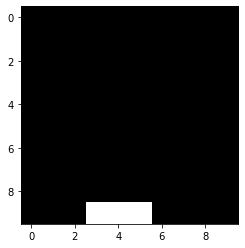

In [186]:
animation = create_policy_animation(best_policy, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

Using a genetic learning algorithm resulted in a much better result in less time than the standard reinforcement learning.

### Find Fruit
Policies take the form of a $(n, n, n, n)$ sized array, where $n$ is the grid size. This accounts for the fruit position (which can take values in an $(n, n)$ space) and the player position (which can take values in an $(n,n)$ space). Entries can take values corresponding to the possible moves of the player (in this case 0, 1, 2, 3, 4)

In [225]:
num_actions = 5

def run_episode(env, policy, episode_len=20):
    total_reward = 0
    obs = env.reset()
    for t in range(episode_len):
        x_fruit, y_fruit, x_player, y_player=env.state
        
        action = policy[x_fruit, y_fruit, x_player, y_player]
        _, reward, done = env.act(action)
        
        total_reward += reward
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, n_episodes=100):
    total_rewards = 0.0
    for _ in range(n_episodes):
        total_rewards += run_episode(env, policy)

    return total_rewards / n_episodes

def gen_random_policy():
    return np.random.choice(num_actions, size=((grid_size, grid_size, grid_size, grid_size)))

def crossover(policy1, policy2):
    new_policy = policy1.copy()
    iterator=[(a,b,c,d) for a in range(grid_size) for b in range(grid_size) 
              for c in range(grid_size) for d in range(grid_size)]
    for i, j, k, l in iterator:
        rand = np.random.uniform()
        if rand > 0.5:
            new_policy[i,j,k,l] = policy2[i,j,k,l]
    return new_policy

def mutation(policy, p=0.05):
    new_policy = policy.copy()
    iterator=[(a,b,c,d) for a in range(grid_size) for b in range(grid_size) 
              for c in range(grid_size) for d in range(grid_size)]
    for i,j,k,l in iterator:
        rand = np.random.uniform()
        if rand < p:
            new_policy[i,j,k,l] = np.random.choice(num_actions)
    return new_policy

In [227]:
env=FindFruit()

n_policy = 100
n_steps = 20
start = time.time()
policy_pop = [gen_random_policy() for _ in range(n_policy)]
for idx in range(n_steps):
    policy_scores = [evaluate_policy(env, p) for p in policy_pop]
    print('Generation %d : max score = %0.2f' %(idx+1, max(policy_scores)))
    policy_ranks = list(reversed(np.argsort(policy_scores)))
    elite_set = [policy_pop[x] for x in policy_ranks[:5]]
    select_probs = np.array(policy_scores) 
    select_probs = list(map(lambda x: max(0,x), select_probs))
    select_probs = select_probs/ np.sum(select_probs)
    
    child_set = [crossover(
        policy_pop[np.random.choice(range(n_policy), p=select_probs)], 
        policy_pop[np.random.choice(range(n_policy), p=select_probs)])
        for _ in range(n_policy - 5)]
    mutated_list = [mutation(p) for p in child_set]
    policy_pop = elite_set
    policy_pop += mutated_list
policy_score = [evaluate_policy(env, p) for p in policy_pop]
best_policy = policy_pop[np.argmax(policy_score)]

end = time.time()
print('Best policy score = %0.2f. Time taken = %4.4f'
        %(np.max(policy_score), (end-start)))

Generation 1 : max score = 1.09
Generation 2 : max score = 1.11
Generation 3 : max score = 1.10
Generation 4 : max score = 1.24
Generation 5 : max score = 1.43
Generation 6 : max score = 1.27
Generation 7 : max score = 1.40
Generation 8 : max score = 1.21
Generation 9 : max score = 1.08
Generation 10 : max score = 0.93
Generation 11 : max score = 0.92
Generation 12 : max score = 0.92
Generation 13 : max score = 1.11
Generation 14 : max score = 1.29
Generation 15 : max score = 1.23
Generation 16 : max score = 1.07
Generation 17 : max score = 1.26
Generation 18 : max score = 1.27
Generation 19 : max score = 1.61
Generation 20 : max score = 1.13
Best policy score = 1.31. Time taken = 175.3590


In [228]:
def create_policy_animation(policy, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            x_fruit, y_fruit, x_player, y_player=env.state

            action = policy[x_fruit, y_fruit, x_player, y_player]
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
animation = create_policy_animation(best_policy, env, num_episodes=3)
IPython.display.HTML(animation.to_jshtml())

Rewards in Animation: [0, 0, 0]
